# Setup


## Importing Data Analysis Libraries

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Useful Constants

In [99]:
DATASETS = ['dataset/TCGA_GBM_LGG_Mutations_all.csv', './dataset/TCGA_InfoWithGrade.csv']
GRADE = ['LGG','GBM']
PROJECT = ['TCGA-GBM', 'TCGA-GBM']
GENDER = ['Male', 'Female']
PRIMARY_DIAGNOSIS = ['Oligodendroglioma, NOS', 'Mixed glioma', 'Astrocytoma, NOS', 'Astrocytoma, anaplastic', 'Oligodendroglioma, anaplastic', 'Glioblastoma']
RACE = ['White', 'Black or African American', 'Asian', 'American Indian or Alaska Native']
GENES = ['IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']
MUTATION = ['Not Mutated', 'Mutated']

# Dataset
> Gliomas are the most common primary tumors of the brain. They can be graded as LGG (Lower-Grade Glioma) or GBM (Glioblastoma Multiforme) depending on the histological/imaging criteria. Clinical and molecular/mutation factors are also very crucial for the grading process. Molecular tests are expensive to help accurately diagnose glioma patients.
> In this dataset, the most frequently mutated 20 genes and 3 clinical features are considered from TCGA-LGG and TCGA-GBM brain glioma projects.
> The prediction task is to determine whether a patient is LGG or GBM with a given clinical and molecular/mutation features. The main objective is to find the optimal subset of mutation genes and clinical features for the glioma grading process to improve performance and reduce costs
> -- <cite>https://www.kaggle.com/datasets/vinayjose/glioma-grading-clinical-and-mutation-features/data</cite>

By analyzing both provided datasets:
- **TCGA_GBM_LGG_Mutations_all.csv** : Values with full information in text format
-  **TCGA_InfoWithGrade** : Cleaned dataset values and integer encoding. 
In order to know wich variables we are working with in this dataset, we decided to create variables that depict the meaning of each value from each column of the `TCGA_InfoWithGrade.csv` file. We will be using this dataset as its data is presented in an easier way to manipulate. 

## Dataset Pre-processing
Due to the vast extensity of the provided dataset, we decided to remove every row that presentes at least one missing value. This way, we can ensure that the dataset is clean and ready to be used for the analysis.

In [100]:
df_all = pd.read_csv(DATASETS[0])
df_all.replace(['--', 'not reported'], pd.NA, inplace=True)
df_all.dropna(inplace=True)

df_with_grade =  pd.read_csv(DATASETS[1])

## Distributions

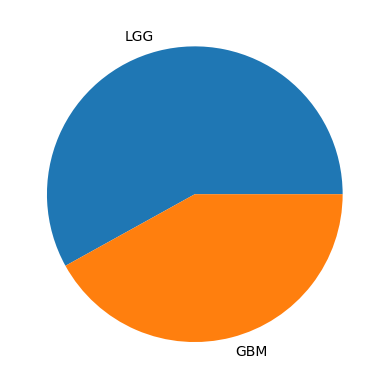

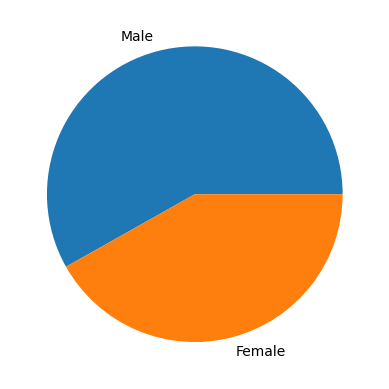

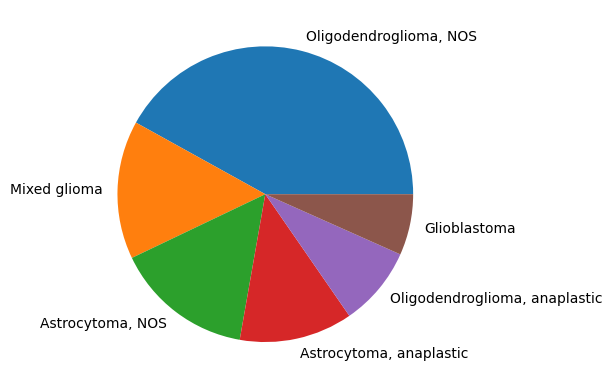

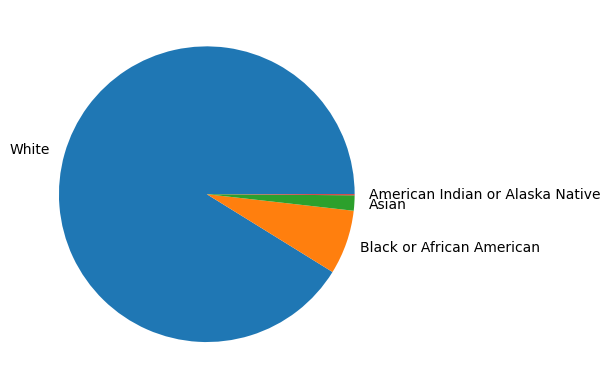

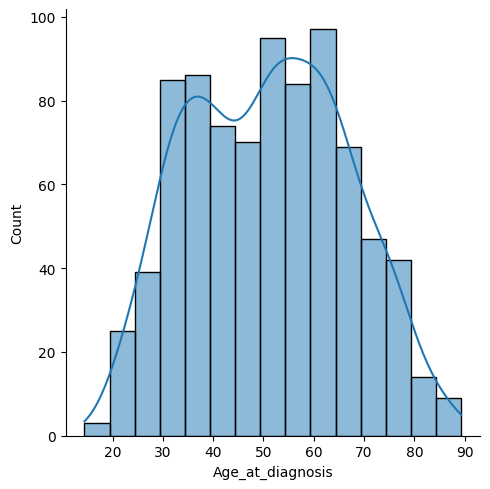

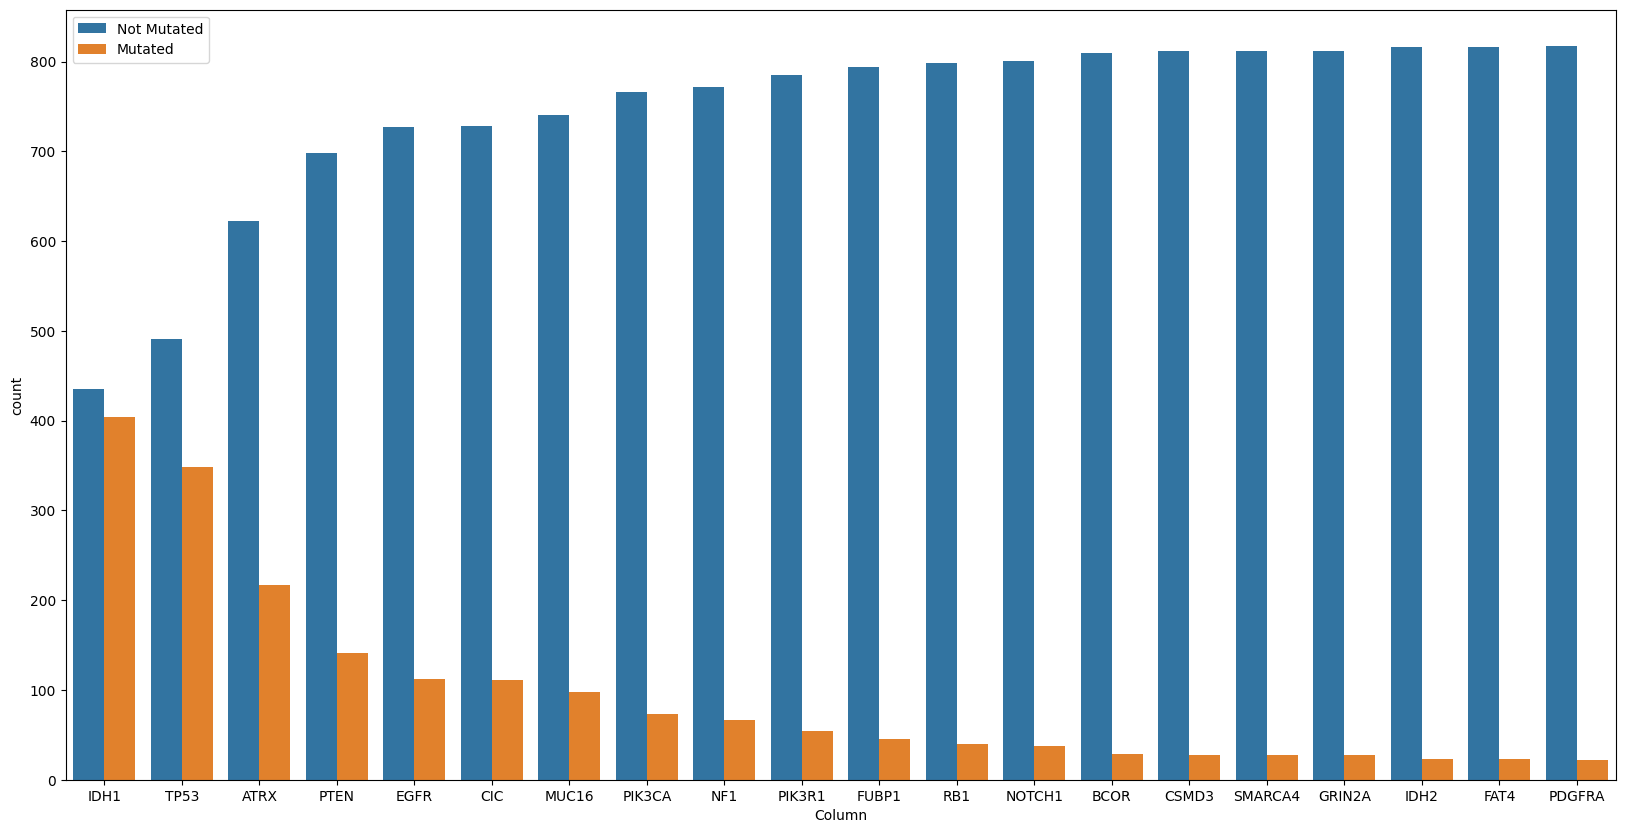

In [101]:
plt.figure()
plt.pie(
    x=df_all['Grade'].value_counts(),
    labels=GRADE,
) 

plt.figure()
plt.pie(
    x= df_all['Gender'].value_counts(),
    labels=GENDER,
) 

plt.figure()
plt.pie(
    x= df_all['Primary_Diagnosis'].value_counts(),
    labels=PRIMARY_DIAGNOSIS,
)

plt.figure()
plt.pie(
    x= df_all['Race'].value_counts(),
    labels=RACE,
)

sns.displot(df_with_grade, kde=True, x='Age_at_diagnosis')
# sns.displot(df_with_grade, kde=True, x='Age_at_diagnosis', hue='Grade')

plt.figure(figsize=(20, 10))
melted_df = df_with_grade[GENES].melt(var_name='Column', value_name='Value')
sns.countplot(data=melted_df, x='Column', hue='Value')
plt.legend(MUTATION)

plt.show()

### Training the dataset

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

X = df_with_grade.drop('Grade', axis=1)
y = df_with_grade['Grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

Feature selection, which basically consists of selecting a subset of features from the original set of features, is used to either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.
Our set is not very high-dimensional, but we will still use feature selection to improve the accuracy of our estimators.

Feature selection is done as a pre-processing step before the actual learning takes place. The idea is to remove non-informative or irrelevant features from the dataset. 
We have tested the following methods to perform feature selection:

### LASSO L1-based feature selection
LASSO (Least Absolute Shrinkage and Selection Operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. LASSO penalizes the absolute size of the regression coefficients, which allows for variable selection. The L1 penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter λ is sufficiently large. Therefore, LASSO can be used for feature selection. Notice that bigger λ results in fewer features selected.

In [103]:
from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Lasso

from src.feature_selection import get_selected_features_names, len_selected_features

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.02)
lasso.fit(x_train_scaled, y_train)

model = SelectFromModel(lasso, prefit=True)
print(len_selected_features(model.get_support()), " selected features")
print(get_selected_features_names(model.get_support()))

12  selected features
['1-Age_at_diagnosis', '3-IDH1', '4-TP53', '6-PTEN', '8-CIC', '9-MUC16', '11-NF1', '12-PIK3R1', '14-RB1', '15-NOTCH1', '19-GRIN2A', '20-IDH2']


### Tree based feature selection 
Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features. Decision trees and ensembles of decision trees often feature importance values, which are used to discard irrelevant features. Here we will use the Random Forest classifier to compute feature importances.

In [104]:
from sklearn.ensemble import RandomForestClassifier

et = RandomForestClassifier(n_estimators=50)
et.fit(X_train, y_train)

model = SelectFromModel(et, prefit=True)
print(len_selected_features(model.get_support()), " selected features")
print(get_selected_features_names(model.get_support()))

3  selected features
['1-Age_at_diagnosis', '3-IDH1', '6-PTEN']


### Recursive feature elimination
Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per iteration, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

In [105]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe = RFE(estimator=LogisticRegression(max_iter=1000)) # Here, we set the number of features to be selected
rfe.fit(X_train, y_train)
print(len_selected_features(rfe.get_support()), " selected features")
print(get_selected_features_names(rfe.support_))

11  selected features
['3-IDH1', '4-TP53', '6-PTEN', '8-CIC', '9-MUC16', '11-NF1', '12-PIK3R1', '15-NOTCH1', '18-SMARCA4', '19-GRIN2A', '20-IDH2']


# Evaluation Metrics

For each model, we will be using the following metrics to evaluate the model's performance:

## Confusion Matrix
The confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. 
To understand the confusion matrix, we need to understand the following terms:
- `True Positive (TP)` (*top-left*): The number of correct predictions that an instance is positive.
- `True Negative (TN)` (*top-right*): The number of correct predictions that an instance is negative.
- `False Positive (FP)` (*bottom-left*): The number of incorrect predictions that an instance is positive.
- `False Negative (FN)` (*bottom-right*): The number of incorrect predictions that an instance is negative.

Having higher values of `TP` and `TN` and lower values of `FP` and `FN` is the goal of any classification model.

## Accuracy

Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

```Accuracy = (TP + TN) / (TP + TN + FP + FN)```

## Classification Report
The classification report is a text summary of the precision, recall, F1 score, and support for each class.

- ### Precision (PRE)
Precision is the ratio of correctly predicted positive observations to the total predicted positives. The question that this metric answers is of **all patients that have glioma, how many actually have glioma?**

```PRE = TP / (TP + FP)```

- ### Recall (REC)
Recall is the ratio of correctly predicted positive observations to the all observations in actual class. The question that this metric answers is of **all the patients that have glioma, how many did we predict correctly?**

```REC = TP / (TP + FN)```

- ### F1 Score (F1)
The F1 score is the weighted average of **Precision** and **Recall**. Therefore, this score takes both false positives and false negatives into account. It is a good way to show that a classifer has a good value for both false positives and false negatives.

```F1 = 2 * PRE * REC / (PRE + REC)```

- ### Support
Support is the number of actual occurrences of the class in the specified dataset.

# Supervised Learning



## Logistical Regression (LR)
The first model we will be using is the `Logistical Regression`. This model is a classification model that is used to predict the probability of a target variable. In this case, we will be using it to predict the type of glioma a patient has (`LGG` or `GBM`) based on the clinical and molecular features provided in the dataset.

### Evaluating the model

In [106]:
from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression(max_iter=2000)
lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)

### Evaluation Metrics

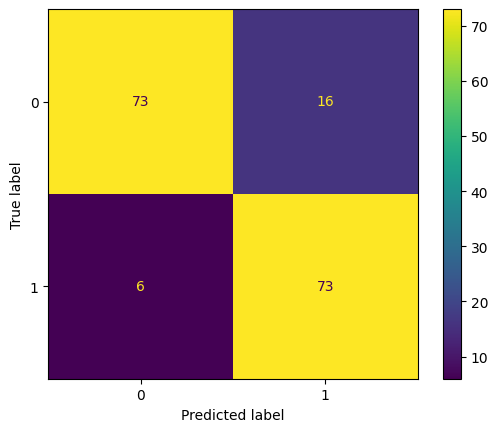

Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        89
           1       0.82      0.92      0.87        79

    accuracy                           0.87       168
   macro avg       0.87      0.87      0.87       168
weighted avg       0.88      0.87      0.87       168



In [107]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))


### Coefficient Interpretation
We use the `coef_` attribute of the logistic regression model to get the coefficients of each feature. The coefficients help us understand the weight of each feature in the model:
- The more positive the coefficient is, the more likely it is to be a `GBM` case.
- The more negative the coefficient is, the more likely it is to be a `LGG` case.
- The closer the coefficient is to zero, the less impact it has on the model.

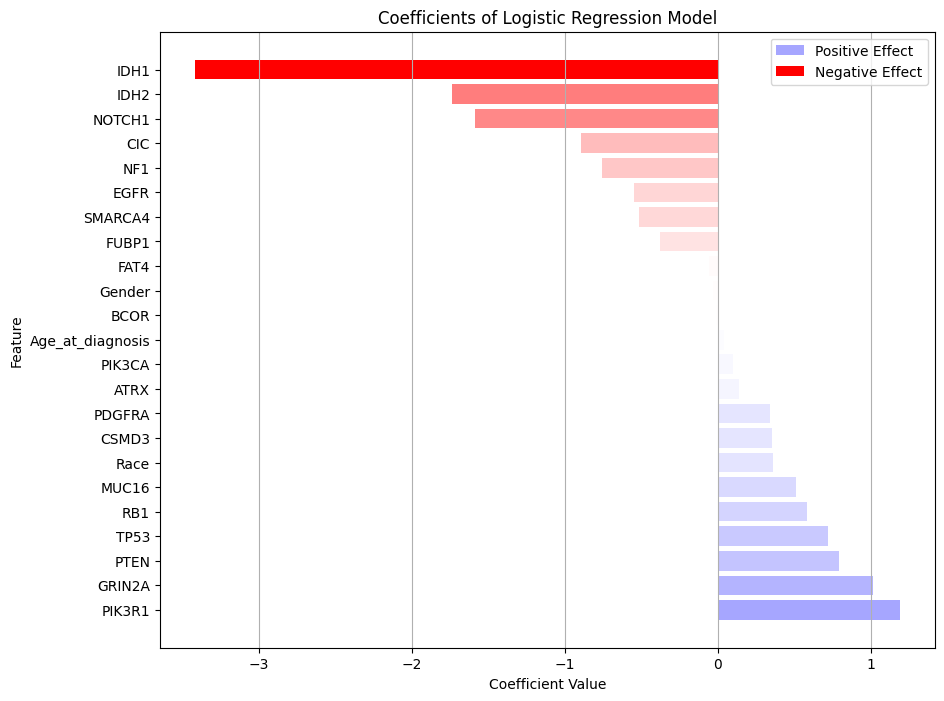

In [108]:
coefficients = dict(zip(X.columns, lg_model.coef_[0]))
sorted_coefficients = dict(sorted(coefficients.items(), key=lambda item: item[1], reverse=True))

features = list(sorted_coefficients.keys())                         # List of Variables
coef_values = list(sorted_coefficients.values())                    # Weight of each variable
colors = ['red' if coef < 0 else 'blue' for coef in coef_values]    
intensities = np.abs(coef_values) / np.max(np.abs(coef_values)) 

plt.figure(figsize=(10, 8))
bars = plt.barh(features, coef_values, color=colors)

for bar, intensity in zip(bars, intensities):
    bar.set_alpha(intensity)

plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Logistic Regression Model')
plt.grid(axis='x')
plt.legend(handles=[bars[0], bars[-1]], labels=['Positive Effect', 'Negative Effect'])
plt.show()

## Support Vector Machine (SVM)
The second model we will be using is the `Support Vector Machine`. This model is a classification model that is used to separate data points into classes by finding the hyperplane that best divides the data points into classes. In this case, we will be using it to predict the type of glioma a patient has (`LGG` or `GBM`) based on the clinical and molecular features provided in the dataset.

### Evaluating the model

In [109]:
from sklearn import svm

svm_model = svm.SVC(kernel="linear", probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

### Evaluation Metrics

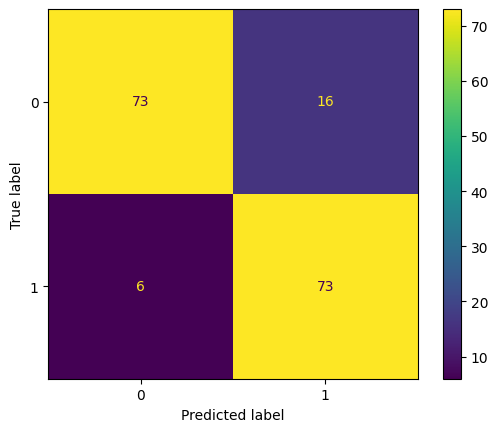

Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        89
           1       0.82      0.92      0.87        79

    accuracy                           0.87       168
   macro avg       0.87      0.87      0.87       168
weighted avg       0.88      0.87      0.87       168



In [110]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

### Coefficient Interpretation

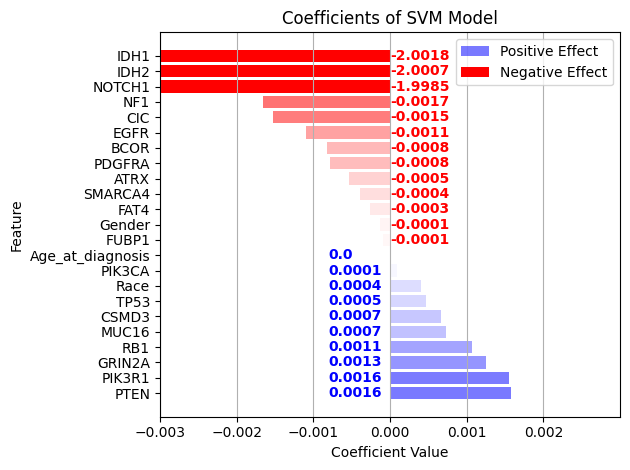

In [111]:
coefficients = dict(zip(X.columns, svm_model.coef_[0]))
sorted_coefficients = dict(sorted(coefficients.items(), key=lambda item: item[1], reverse=True))

features = list(sorted_coefficients.keys())                         # List of Variables
coef_values = list(sorted_coefficients.values())                    # Weight of each variable
colors = ['red' if coef < 0 else 'blue' for coef in coef_values]    
intensities = np.abs(coef_values) / 0.003

fig, ax = plt.subplots()
bars = plt.barh(features, coef_values, color=colors)

for bar, intensity in zip(bars, intensities):
    bar.set_alpha(min(intensity, 1))

for bar, coef in zip(bars, coef_values):
    if coef < 0:
        ax.text(0, features[coef_values.index(coef)], round(coef, 4), color='red', fontweight='bold', verticalalignment='center')
    else:
        ax.text(-0.0008, features[coef_values.index(coef)], round(coef, 4), color='blue', fontweight='bold', verticalalignment='center')

plt.xticks(np.arange(-0.003, 0.003, step=0.001))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of SVM Model')
plt.grid(axis='x')
plt.legend(handles=[bars[0], bars[-1]], labels=['Positive Effect', 'Negative Effect'])

plt.xlim(-0.003, 0.003)  # Set the limits to the interval [-0.003, 0.003]
plt.tight_layout()
plt.show()

By comparing this model's coefficients with the previous model's coefficients (Logistical Regression), we can see similarities in the genes order and their impact on the prediction of the glioma type. However, we can see that the `IDH1`, `IDH2`, and `NOTCH1` genes have an immense impact in the prediction of the `LGG` glioma type - the three specified genes coefficients have an order of magnitude of 10⁰ while the other genes have an order of magnitude of 10⁻⁴. This difference between both models is due to the different roles that coefficients play in each model. In the SVM model, the coefficients are used to define the hyperplane that best divides the data points into classes, while in the Logistical Regression model, the coefficients are used to predict the probability of a target variable.

## K Nearest Neighbors (KNN)
The third model we will be using is the `K Nearest Neighbors`. This model is a classification model that is used to classify data points based on the classes of their nearest neighbors. From different tests, we have concluded that the best number of neighbors to use is 7.

### Evaluating the model

In [112]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

### Evaluation Metrics

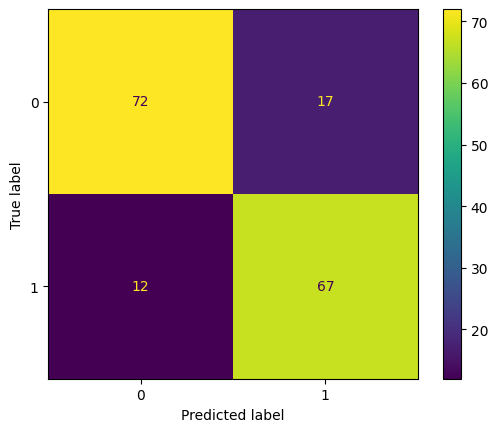

Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        89
           1       0.80      0.85      0.82        79

    accuracy                           0.83       168
   macro avg       0.83      0.83      0.83       168
weighted avg       0.83      0.83      0.83       168



In [113]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

## Random Forest (RF)
The fourth model we will be using is the `Random Forest`. This model is an ensemble learning method that is used for classification and regression. It works by constructing a multitude of decision trees during training and outputs the class that is the mode of the classes of the individual trees. In this case, we will be using it to predict the type of glioma a patient has (`LGG` or `GBM`) based on the clinical and molecular features provided in the dataset. 

### Evaluating the model

In [114]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=150, criterion='gini', min_samples_split=2, min_samples_leaf=2, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

## AdaBoost
The fifth model we will be using is the `AdaBoost`. This model is an ensemble learning method that is used for classification and regression. It works by combining multiple weak learners to create a strong learner. In this case, we will be using it to predict the type of glioma a patient has (`LGG` or `GBM`) based on the clinical and molecular features provided in the dataset.

### Evaluating the model

In [115]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, algorithm='SAMME', random_state=42)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)

## Neural Network (NN)
The sixth model we will be using is the `Neural Network`. In this model we start by determining the best parameters for the model, such as the number of hidden layers, the solver and activation functions as the learning_rate. After that, we will train the model and evaluate its performance with the chosen parameters.

### Determining the best parameters

In [116]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

mlp = MLPClassifier(max_iter=1000)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


### Evaluating the model

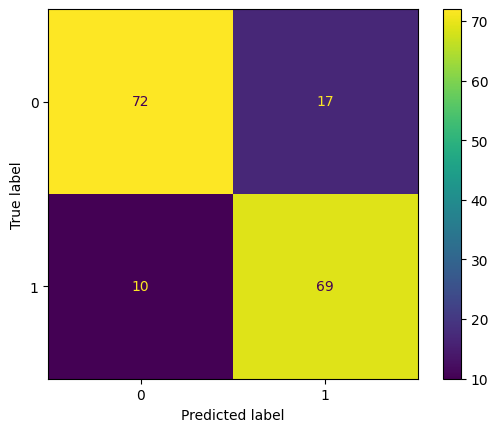

Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        89
           1       0.80      0.87      0.84        79

    accuracy                           0.84       168
   macro avg       0.84      0.84      0.84       168
weighted avg       0.84      0.84      0.84       168



In [117]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='adaptive', solver='adam', max_iter=1000)
nn_model.fit(X_train, y_train)

y_pred = nn_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Ensemble Models

We explore all the possible combinations of the models we have used so far to create ensemble models with Voting Classifier method.

In [120]:
from sklearn.ensemble import VotingClassifier

models = {
    'LR': lg_model,
    'SVM': svm_model,
    'KNN': knn_model,
    'RF': rf_model,
    'AdaBoost': ada_model,
    'NN': nn_model
}

from itertools import combinations

best_accuracy = 0
best_combination = None

for i in range(1, 6):
    for combination in combinations(models.keys(), i):
        voting_model = VotingClassifier(estimators=[(name, models[name]) for name in combination], voting='hard')
        voting_model.fit(X_train, y_train)
        y_pred = voting_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = combination

print(f"Best combination: {best_combination}")
print(f"Accuracy: {best_accuracy:.2f}")

Best combination: ('SVM', 'KNN', 'AdaBoost', 'NN')
Accuracy: 0.88


By running the code before we conclude almost all of the combinations are very similiar in terms of accuracy, they don't pass the 0.88 mark.
So, we choose 6 models combination to check the other metrics.

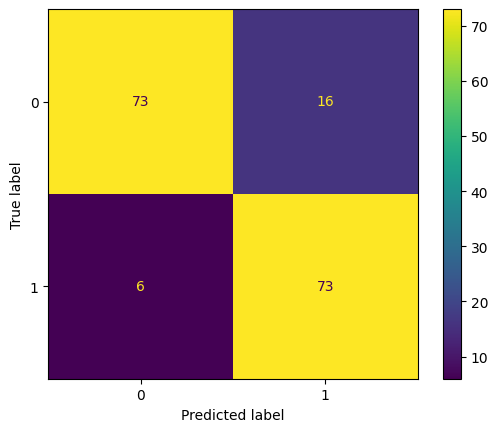

Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        89
           1       0.82      0.92      0.87        79

    accuracy                           0.87       168
   macro avg       0.87      0.87      0.87       168
weighted avg       0.88      0.87      0.87       168



In [119]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('lr', lg_model), ('svm', svm_model), ('knn', knn_model), ('rf', rf_model), ('ada', ada_model), ('nn', nn_model)
], voting='hard')

voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Conclusion

In this Jupyter Notebook, we embarked on a comprehensive analysis of glioma grading using clinical and molecular features from the TCGA-LGG and TCGA-GBM brain glioma projects. Our journey began with dataset exploration and pre-processing, ensuring data cleanliness and readiness for analysis. We delved into distributions of key variables, gaining insights into the demographic and diagnostic characteristics of the patient cohort.

We ventured into supervised learning, employing a range of classification algorithms including Logistic Regression, Support Vector Machine, K Nearest Neighbors, Random Forest, AdaBoost, and Neural Network. Each model underwent rigorous evaluation using metrics like confusion matrix, accuracy, and classification report, offering a comprehensive assessment of its performance.

Furthermore, we explored ensemble models, combining the strengths of multiple classifiers through Voting Classifier. This ensemble approach yielded promising results, showcasing enhanced accuracy and robustness in glioma grading prediction.

Through meticulous analysis and experimentation, we've not only gained insights into the predictive power of various models but also identified optimal feature subsets and ensemble strategies for improving glioma grading accuracy. This work paves the way for future advancements in clinical decision-making and personalized treatment strategies for glioma patients.








